# Testing the Memory using a toy problem

Problem and inspiration from the excellent [Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/).

This notebook was used during development, and can be run to prove the quality of both the Gaussian Mixture and the LSTM.

## Gaussian mixture with a fully connected head

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from worldmodels.memory.memory import GaussianMixture, MLP, Memory
from worldmodels.memory.memory import get_pi_idx
from worldmodels.memory.train_memory import train

In [2]:
NSAMPLE = 20000
epochs = 10

y_data = np.random.uniform(-10.5, 10.5, (1, NSAMPLE)).T
r_data = np.random.normal(size=(NSAMPLE,1))
x_data = np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0

num_timesteps = 1
num_features = 1
num_mix = 24
batch_size = NSAMPLE

y_data = y_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)
x_data = x_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)

#  this will be the shape of the output of the lstm
#  (batch_size, num_timesteps, output_dim * num_mix * 3)
#  three for one pi, mu, sigma for each mixture
mixture_dim = num_features * num_mix * 3
print(mixture_dim)

72


In [3]:
memory = MLP(num_mix, hidden_nodes=24)

In [4]:
mixture = GaussianMixture(num_features, num_mix, num_timesteps=1, batch_size=batch_size)

In [5]:
x_sample = x_data[0:2]
x_sample.shape

(2, 1, 1)

In [6]:
pi, mu, sigma = mixture(memory(x_data))

In [7]:
def train_op(memory, mixture, x, y):
    with tf.GradientTape() as tape:
        loss = mixture.get_loss(memory(x), y)
        gradients = tape.gradient(loss, memory.trainable_variables)

    optimizer.apply_gradients(zip(gradients, memory.trainable_variables))
    return loss

optimizer = tf.keras.optimizers.Adam()
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(NSAMPLE).batch(batch_size)
loss = np.zeros(epochs)

for epoch in range(epochs):
    for batch in dataset:
        loss[epoch] = train_op(memory, mixture, *batch)
    if epoch % 100 == 1:
        print(epoch, loss[epoch])

1 7.239049434661865


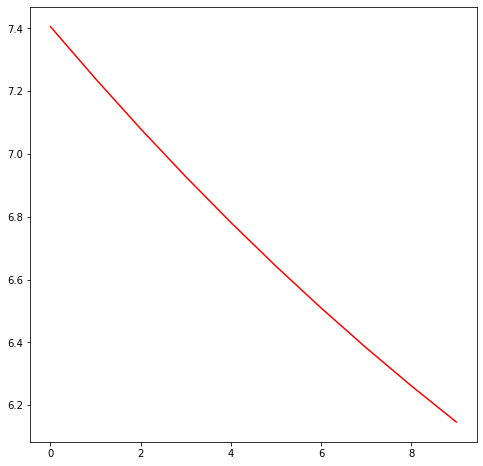

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.style.use('ggplot')
plt.show()

In [9]:
x_test = np.float32(np.arange(-15,15,0.1))
n_test = x_test.shape[0]
x_test = x_test.reshape(n_test, 1, 1)

In [10]:
mus, sigmas, idxs = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)
samples = np.zeros(n_test)

for num, sample in enumerate(x_test):
    pi, mu, sigma = mixture(memory(sample.reshape(1, 1, 1)))
    
    pi = np.array(pi).reshape(1, pi.shape[3])
    mu = np.array(mu).reshape(1, mu.shape[3])
    sigma = np.array(sigma).reshape(1, sigma.shape[3])

    idx = get_pi_idx(pi[0], None)
    
    idxs[num] = idx
    mus[num] = mu[:, idx]
    sigmas[num] = sigma[:, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

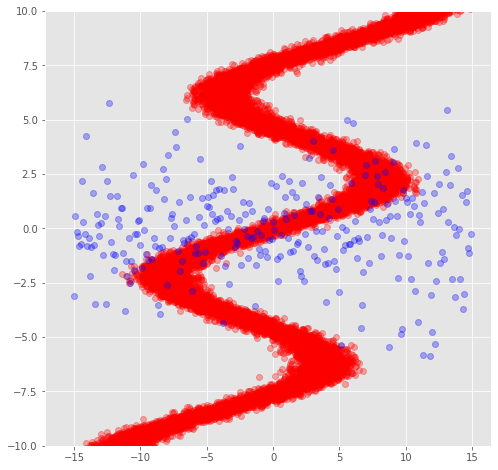

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)
plt.ylim(-10, 10)
plt.savefig('/Users/adam/git/adgefficiency.github.io/assets/world-models/mdn-test1.png')
plt.show()

## Gaussian mixture with an LSTM head

In [12]:
nodes = 32
num_mix = 24

memory = Memory(
    input_dim=1, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    batch_size=batch_size, 
    lstm_nodes=nodes, 
    num_mix=num_mix,
    initial_learning_rate=0.01,
    end_learning_rate=0.0001
)

In [13]:
x = x_data
y = y_data

epochs = 5000
loss = np.zeros(epochs)
dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(1).batch(batch_size)

for epoch in range(epochs):
    for batch in dataset:
        state = memory.lstm.get_zero_hidden_state(batch[0])
        #state[0] = tf.reshape(state[0], (-1, nodes))
        #state[1] = tf.reshape(state[1], (-1, nodes))
        loss[epoch] = memory.train_op(*batch, state)
        
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

1 13.404359817504883
501 8.013659477233887
1001 5.58625602722168
1501 4.4617767333984375
2001 4.013627529144287
2501 3.779078960418701
3001 3.6191153526306152
3501 3.493816375732422
4001 3.385929584503174
4501 3.2909717559814453


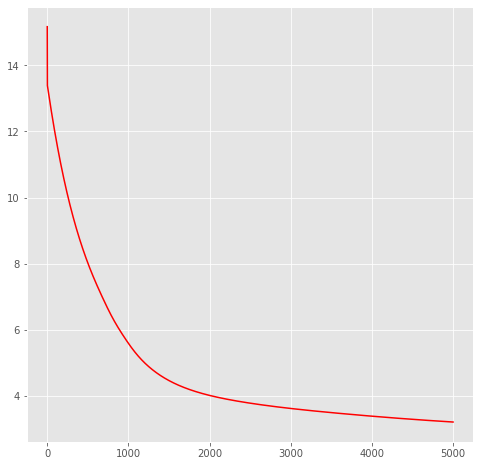

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.show()

In [15]:
#  need to save & load to use a different batch size (when predicting on test)
memory.save('./mdl')

memory = Memory(
    input_dim=1, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    batch_size=batch_size, 
    lstm_nodes=nodes, 
    num_mix=num_mix
)

memory.load('./mdl')

saving model to ./mdl/models
loading model from ./mdl/models


In [16]:
mus, sigmas, idxs, samples = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)

for num, sample in enumerate(x_test):
    sample = sample.reshape(1, 1, 1)
    state = memory.lstm.get_zero_hidden_state(sample)
    latent, _, _ = memory.lstm.net(sample, state)
    pi, mu, sigma = memory.mixture(latent)
    idx = get_pi_idx(tf.reshape(pi, (num_mix,)), 1.1)
    
    idxs[num] = idx
    mus[num] = mu[:, :, :, idx]
    sigmas[num] = sigma[:, :, :, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 1.0000001192092896 thresh 1.1
pdf 1.0000001192092896 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999998211860657 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0000001192092896 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 1.000000238418579 thresh 1.1
pdf 1.0000001192092896 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 0.9999998807907104 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 1.0 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999999403953552 thresh 1.1
pdf 0.9999998807907104 thresh 1.1
pdf 0.9999998807907104 thresh 1.1
pdf 1.0 thresh 1.1
pdf 0.9999998807907104 thresh 1.

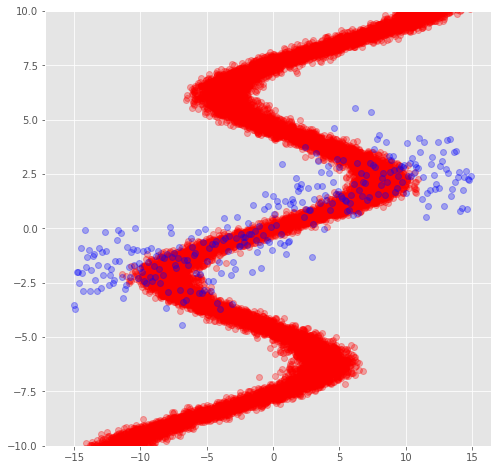

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)
plt.ylim(-10, 10)
plt.savefig('/Users/adam/git/adgefficiency.github.io/assets/world-models/mdn-test2.png')
plt.show()